In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.python.keras.preprocessing.image import load_img, img_to_array

from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.models import load_model

import os

In [38]:
PATH = "../input/dermmel/DermMel/"

PATH_TRAIN = PATH + '/train_sep/'
PATH_VALID = PATH + '/valid/'
PATH_TEST = PATH + '/test/'

In [39]:
#checks the dataset for image counts
def dataset_check(path, type):
    labels = os.listdir(path)
    total = 0
    for label in labels:
        print(label,len(os.listdir(path + label)))
        total += len(os.listdir(path + label))

    print(type,"photos",total)
    print ("\n")

dataset_check(PATH_TRAIN,"training")
dataset_check(PATH_VALID,"validation")
dataset_check(PATH_TEST,"testing")

Melanoma 5341
NotMelanoma 5341
training photos 10682


Melanoma 1781
NotMelanoma 1781
validation photos 3562


Melanoma 1781
NotMelanoma 1780
testing photos 3561




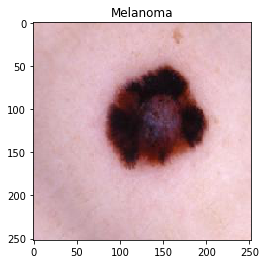

../input/dermmel/DermMel//train_sep//Melanoma/AUG_0_9849.jpeg sample: 77 



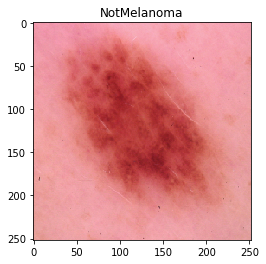

../input/dermmel/DermMel//train_sep//NotMelanoma/ISIC_0026317.jpg sample: 77 



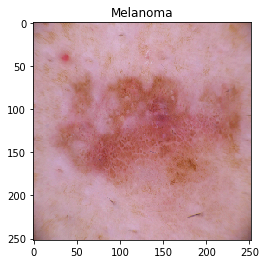

../input/dermmel/DermMel//test//Melanoma/ISIC_0024853.jpg sample: 77 



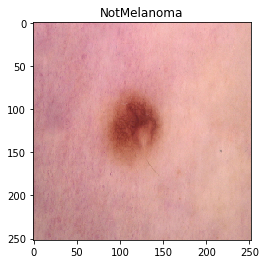

../input/dermmel/DermMel//test//NotMelanoma/ISIC_0030304.jpg sample: 77 



In [40]:
#displays sample image
def dataset_display(path, sample, type):
    img_path = path + '/' + type + '/'
    img_name = os.listdir(img_path)[sample]
    img_path_full = img_path + img_name
    img = load_img(img_path_full, target_size=(252, 252))
    imgplot = plt.imshow(img)
    plt.title(type)
    plt.show()
    return img_path_full

sample_num = 77

print(dataset_display(PATH_TRAIN, sample_num, 'Melanoma'),'sample:',sample_num,'\n')
print(dataset_display(PATH_TRAIN, sample_num, 'NotMelanoma'),'sample:',sample_num,'\n')
print(dataset_display(PATH_TEST, sample_num, 'Melanoma'),'sample:',sample_num,'\n')
print(dataset_display(PATH_TEST, sample_num, 'NotMelanoma'),'sample:',sample_num,'\n')

In [41]:
conv_base = ResNet50(weights='imagenet',
                     include_top=False,
                     input_shape=(224, 224, 3))

In [42]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='sigmoid'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                6422592   
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 30,010,434
Trainable params: 29,957,314
Non-trainable params: 53,120
___________________________________________________________

In [43]:
for layer in conv_base.layers[:]:
    layer.trainable = False

In [44]:
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                6422592   
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 30,010,434
Trainable params: 6,422,722
Non-trainable params: 23,587,712
________________________________________________________

In [45]:
batch_size = 20
target_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(PATH_TRAIN,
                                              target_size=target_size,
                                              batch_size=batch_size)

valid_gen = test_datagen.flow_from_directory(PATH_VALID,
                                             target_size=target_size,
                                             batch_size=batch_size)

test_gen = test_datagen.flow_from_directory(PATH_TEST,
                                            target_size=target_size,
                                            batch_size=batch_size)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [46]:
history = model.fit_generator(train_gen,
                              epochs=2,
                              steps_per_epoch = 4096 // batch_size,
                              validation_data = valid_gen,
                              validation_steps = 2048 // batch_size)

Epoch 1/2
204/204 [==============================] - 99s 488ms/step - loss: 0.7152 - acc: 0.7522 - val_loss: 0.4231 - val_acc: 0.8917
Epoch 2/2
204/204 [==============================] - 92s 452ms/step - loss: 0.6173 - acc: 0.7886 - val_loss: 0.4035 - val_acc: 0.9458


In [47]:
for layer in conv_base.layers[:165]:
    layer.trainable = False
for layer in conv_base.layers[165:]:
    layer.trainable = True

In [48]:
model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [49]:
history = model.fit_generator(train_gen,
                              epochs=32,
                              steps_per_epoch = 4096 // batch_size,
                              validation_data = valid_gen,
                              validation_steps = 2048 // batch_size)

Epoch 1/32
204/204 [==============================] - 108s 530ms/step - loss: 0.5572 - acc: 0.8456 - val_loss: 0.3716 - val_acc: 0.9350
Epoch 2/32
204/204 [==============================] - 98s 478ms/step - loss: 0.5092 - acc: 0.8536 - val_loss: 0.3490 - val_acc: 0.9419
Epoch 3/32
204/204 [==============================] - 102s 499ms/step - loss: 0.4874 - acc: 0.8471 - val_loss: 0.3514 - val_acc: 0.9279
Epoch 4/32
204/204 [==============================] - 100s 488ms/step - loss: 0.4422 - acc: 0.8592 - val_loss: 0.3255 - val_acc: 0.9310
Epoch 5/32
204/204 [==============================] - 100s 492ms/step - loss: 0.4393 - acc: 0.8605 - val_loss: 0.3172 - val_acc: 0.9385
Epoch 6/32
204/204 [==============================] - 98s 482ms/step - loss: 0.4226 - acc: 0.8723 - val_loss: 0.3113 - val_acc: 0.9364
Epoch 7/32
204/204 [==============================] - 94s 463ms/step - loss: 0.3849 - acc: 0.8847 - val_loss: 0.3099 - val_acc: 0.9332
Epoch 8/32
204/204 [==============================]

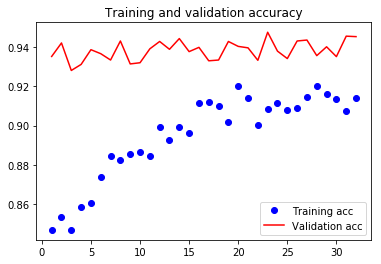

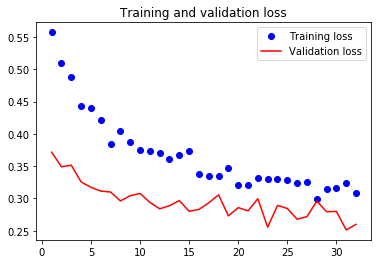

In [60]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

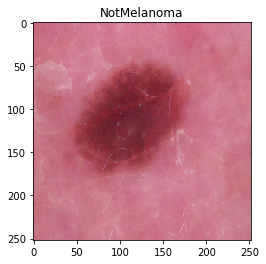

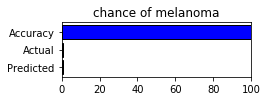

Predicted chance of melanoma: 0.0%
Actual: 0%
Difference: 0.0%




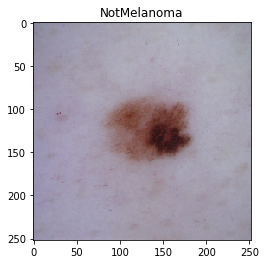

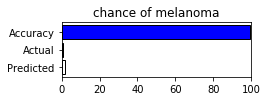

Predicted chance of melanoma: 0.7799999999999999%
Actual: 0%
Difference: 0.78%




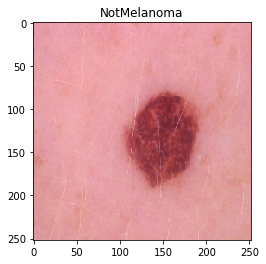

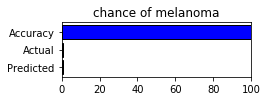

Predicted chance of melanoma: 0.0%
Actual: 0%
Difference: 0.0%




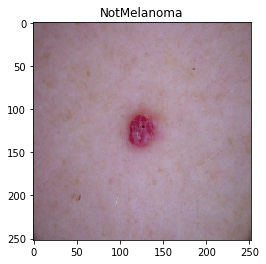

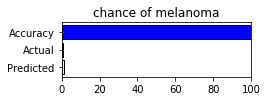

Predicted chance of melanoma: 0.38%
Actual: 0%
Difference: 0.38%




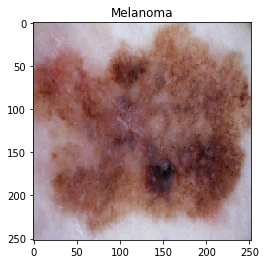

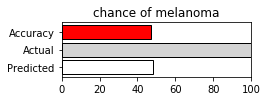

Predicted chance of melanoma: 47.28%
Actual: 100%
Difference: 52.72%




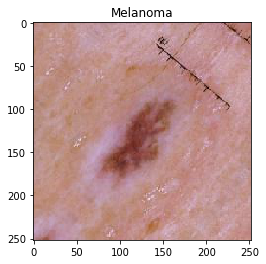

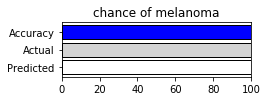

Predicted chance of melanoma: 100.0%
Actual: 100%
Difference: 0.0%




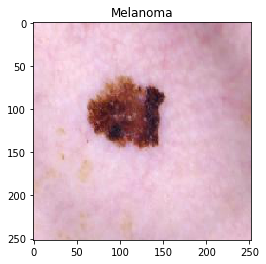

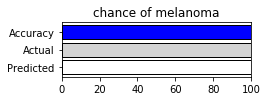

Predicted chance of melanoma: 100.0%
Actual: 100%
Difference: 0.0%




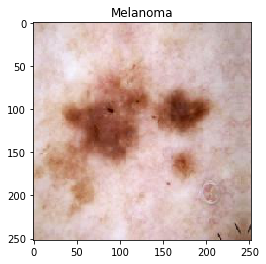

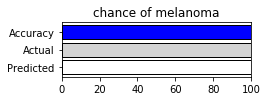

Predicted chance of melanoma: 100.0%
Actual: 100%
Difference: 0.0%




In [51]:
def display_results(img_num, check_type):
    def load_image(img_path_full, show = False):
        img = image.load_img(img_path_full, target_size = (224, 224))
        img_tensor = image.img_to_array(img)
        img_tensor = np.expand_dims(img_tensor, axis = 0)
        img_tensor /= 255
        
        return img_tensor
    
    PROOF_PATH = dataset_display(PATH_TEST, img_num, check_type)
    pred = model.predict(load_image(PROOF_PATH))
    pred = round(float(pred[0][0]),4)*100
    actual = 100 if check_type == 'Melanoma' else 0
    diff = abs(round(pred-actual,4))
    
    y = ['Predicted','Actual','Accuracy']
    x = [pred+1,actual+1,(100-diff)]
    
    f = plt.figure()
    f.set_figwidth(3.4)
    f.set_figheight(1)
    plt.title('chance of melanoma')
    plt.barh(y,x,color=['white', 'lightgrey','b' if 100-diff > 76 else 'r'],edgecolor='black')
    plt.xlim([0,100])
    plt.show()
    
    print (f'Predicted chance of melanoma: {pred}%')
    print (f"Actual: {actual}%")
    print (f'Difference: {diff}%')
    print('\n')

for i in range(4,8):
    display_results(i,'NotMelanoma')
for i in range(4,8):
    display_results(i,'Melanoma')

In [52]:
test_loss, test_acc = model.evaluate_generator(test_gen, steps = 2048 // batch_size, verbose=1)
print('test accuracy:', test_acc)
print('test loss:', test_loss)

102/102 [==============================] - 25s 247ms/step
test accuracy: 0.9316176398127687
test loss: 0.28414130955934525


In [53]:
model.save('melanoma_resnet50.h5')